In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp,sqrt
from scipy import optimize as op

In [203]:
df=pd.read_csv('data/04_cricket_1999to2011.csv')


FileNotFoundError: ignored

In [185]:
print(df.columns)


Index(['Match', 'Date', 'Innings', 'Over', 'Runs', 'Total.Runs',
       'Innings.Total.Runs', 'Runs.Remaining', 'Total.Out',
       'Innings.Total.Out', 'Outs.Remaining', 'Wickets.in.Hand', 'Run.Rate',
       'Innings.Run.Rate', 'Run.Rate.Required', 'Initial.Run.Rate.Required',
       'Target.Score', 'Day-night', 'At.Bat', 'Fielding', 'Home.Team',
       'Away.Team', 'Stadium', 'Country', 'Total.Overs', 'Winning.Team',
       'Toss.Winner', 'at.bat.wins', 'at.bat.won.toss', 'at.bat.at.home',
       'at.bat.bat.first', 'chose_bat_1st', 'chose_bat_2nd', 'forced_bat_1st',
       'forced_bat_2nd', 'new.game', 'Error.In.Data', 'common.support'],
      dtype='object')


In [186]:
print(df.iloc[0:5][['Runs','Runs.Remaining','Innings.Total.Runs']])

   Runs  Runs.Remaining  Innings.Total.Runs
0     4             200                 204
1     2             198                 204
2     3             195                 204
3     2             184                 204
4     6             167                 204


#**Modifying columns of our use**

In [187]:
df=df[df['Innings']==1]
DLS_df=df[['Over','Innings.Total.Runs', 'Runs', 'Total.Runs','Wickets.in.Hand']]

In [188]:
DLS_df.head()


,Over,Innings.Total.Runs,Runs,Total.Runs,Wickets.in.Hand
0,1,204,4,4,10
1,2,204,2,6,10
2,3,204,3,9,10
3,4,204,2,20,10
4,5,204,6,37,10


In [189]:


#solving descrepency in the column Total.Runs
for i in range(len(DLS_df)):
  if DLS_df.iloc[i]['Over']==1:
    DLS_df.iloc[i]['Total.Runs']=DLS_df.iloc[i]['Runs']

  else:
    DLS_df.iloc[i]['Total.Runs']=DLS_df.iloc[i]['Runs']+DLS_df.iloc[i-1]['Total.Runs']  




#Objective Function
asssuming the model</br>
Z(u,w) = Z0(w)[1 - exp{-Lu/Z0(w)}]


In [190]:
def objective_fun(x,DLS_df):
  L=x[10]
  error=0
  for w in range(1,11):
      df = DLS_df[DLS_df['Wickets.in.Hand']==w]
      overs = 50-df['Over']
      runs = df['Innings.Total.Runs']-df['Total.Runs']
      pruns = x[w-1]*np.subtract(1,np.exp(np.multiply(-1*L/x[w-1],overs)))

   #initial case when wicket_remaining=10 and over left=50
      if(w==10):
        DF=DLS_df[DLS_df['Over']==1]
        runs=DF['Innings.Total.Runs']
        pruns = x[9]*np.subtract(1,np.exp(np.multiply(-1*L/x[9],50)))
        error+=(np.sum(np.square(np.subtract(runs,pruns))))
      

      error+=(np.sum(np.square(np.subtract(runs,pruns))))

  
      
  return error/len(DLS_df)


# Duckworth-Lewis-Stern Method

In [200]:
def DuckworthLewis11Params(obj):
    x0 = 1*np.ones(11)
    x0[10]=0.1
    res=op.minimize(fun=obj,x0=x0,args=( DLS_df))
      
    return res

In [195]:
def error_fun(X):
   Z=X[:10]
   L=X[10]
   total_error=objective_fun(X,DLS_df)
   errors = np.zeros(10)
   for w in range(1,11):
        df =  DLS_df[ DLS_df['Wickets.in.Hand']==w]
        overs = 50-df['Over']
        runs = df['Innings.Total.Runs']-df['Total.Runs']
        pruns = Z[w-1]*np.subtract(1,np.exp(np.multiply(-1*L/Z[w-1],overs)))
        errors[w-1]=(np.sum(np.square(np.subtract(runs,pruns))))/len( df)
   return errors, total_error     


In [196]:
def plot1(Z,L):
    Z_N=(Z[9]*(1-exp(-1*L*50/Z[9])))
    for w in range(1,11):
        overs_left = range(0,51)
        resource_used= np.array([100*(Z[w-1]*(1-exp(-1*L*o/Z[w-1])))/Z_N for o in overs_left])
        plt.plot(overs_left,resource_used,label=str(w))
        plt.text(overs_left[-5],resource_used[-5],w)
    plt.xlabel("Overs Remaining")
    plt.ylabel("percentage of resource remaining")
    
    plt.show()

In [197]:
def plot2(Z,L):
    
    for w in range(1,11):
        overs_left = range(0,51)
        resource_used= np.array([(Z[w-1]*(1-exp(-1*L*o/Z[w-1]))) for o in overs_left])
        plt.plot(overs_left,resource_used,label=str(w))
        plt.text(overs_left[-5],resource_used[-5],w)
    plt.xlabel("Overs Remaining")
    plt.ylabel("predicted Run")
    
    plt.show()

[ 12.25584143  27.48688407  51.37536985  79.03887109 103.83077335
 137.56035035 168.6749492  206.98612638 238.26168317 274.69394667
  10.98208189]


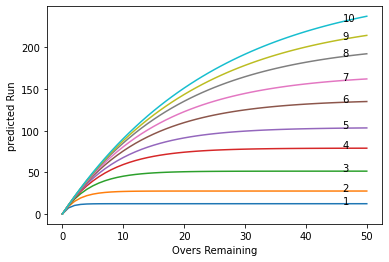

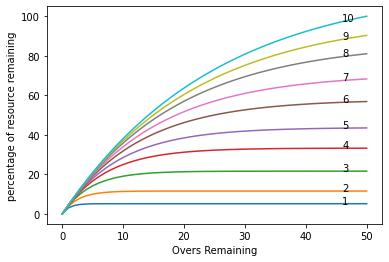

Normalised square Error for each wicket:  1339.4647420475724
value of L is:  10.982081886359008 

Z0 are: [ 12.25584143  27.48688407  51.37536985  79.03887109 103.83077335
 137.56035035 168.6749492  206.98612638 238.26168317 274.69394667] 

Normalised square Error for each wicket [ 114.66380376  243.09489379  446.86075805  631.99948657  852.94443948
 1079.72480524 1338.26182036 1820.98477523 2388.8089001  2812.50369179]


In [202]:
res = DuckworthLewis11Params(objective_fun)
X=res.x
print(X)
errors,total_error=error_fun(X)
Z0=X[:10]
L=X[10]
plot2(Z0,L)

plot1(Z0,L)

print("Normalised square Error for each wicket: ",total_error)
print("value of L is: ",L,"\n")
print("Z0 are:",Z0,"\n")
print("Normalised square Error for each wicket",errors)